In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import uuid

In [5]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

data_dir = 'cell_images'

In [6]:
# Function to load image paths and labels
def load_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    categories = ['Uninfected', 'Parasitized']
    label_map = {'Uninfected': 0, 'Parasitized': 1}
    
    for category in categories:
        folder_path = os.path.join(data_dir, category)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            if img_name.endswith('.png'):
                image_paths.append(img_path)
                labels.append(label_map[category])
    
    return image_paths, labels

In [7]:
# Load dataset
image_paths, labels = load_image_paths_and_labels(data_dir)
print(f'Jami tasvirlar soni: {len(image_paths)}')

Jami tasvirlar soni: 27552


In [8]:
# Split into train/validation/test (60% train, 20% validation, 20% test)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.25, random_state=42, stratify=train_labels
)

print(f'Trening to‘plami hajmi: {len(train_paths)}')
print(f'Validatsiya to‘plami hajmi: {len(val_paths)}')
print(f'Test to‘plami hajmi: {len(test_paths)}')

Trening to‘plami hajmi: 16530
Validatsiya to‘plami hajmi: 5511
Test to‘plami hajmi: 5511


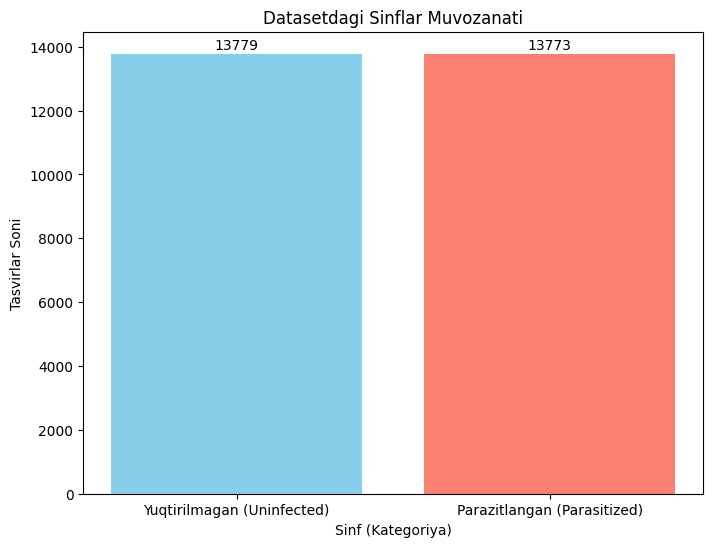

In [ ]:
from collections import Counter

label_counts = Counter(labels)
categories_display = ['Parazitlanmagan (Uninfected)', 'Parazitlangan (Parasitized)']
counts = [label_counts[0], label_counts[1]] 

plt.figure(figsize=(8, 6))
plt.bar(categories_display, counts, color=['skyblue', 'salmon'])
plt.title('Datasetdagi Sinflar Muvozanati')
plt.xlabel('Sinf (Kategoriya)')
plt.ylabel('Tasvirlar Soni')
for i, count_val in enumerate(counts):
    plt.text(i, count_val + 50, str(count_val), ha='center', va='bottom')
plt.show()

In [16]:
# Custom Dataset class
class MalariaDataset(Dataset):
    def __init__(self, image_paths, labels, target_size=(128, 128), augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.target_size = target_size
        self.augment = augment
        
        # MalariaDataset __init__ metodidan (transformlar tarkibida):
        self.base_transform = transforms.Compose([
            transforms.ToTensor(), # [0, 255] oralig'idagi qiymatlarni [0, 1] ga o'tkazadi
        ])
        
        if augment:
            self.augment_transform = transforms.Compose([
                transforms.RandomRotation(20),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomResizedCrop(target_size, scale=(0.8, 1.2)),
                transforms.ToTensor(),
            ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load and preprocess image
        img = cv2.imread(img_path)
        
        # MalariaDataset __getitem__ metodidan:
        img = cv2.resize(img, self.target_size)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        
        # Convert to PIL Image for torchvision transforms
        from PIL import Image
        img = Image.fromarray(img)
        
        # Apply transforms
        if self.augment:
            img = self.augment_transform(img)
        else:
            img = self.base_transform(img)
        
        return img, torch.tensor(label, dtype=torch.float32)


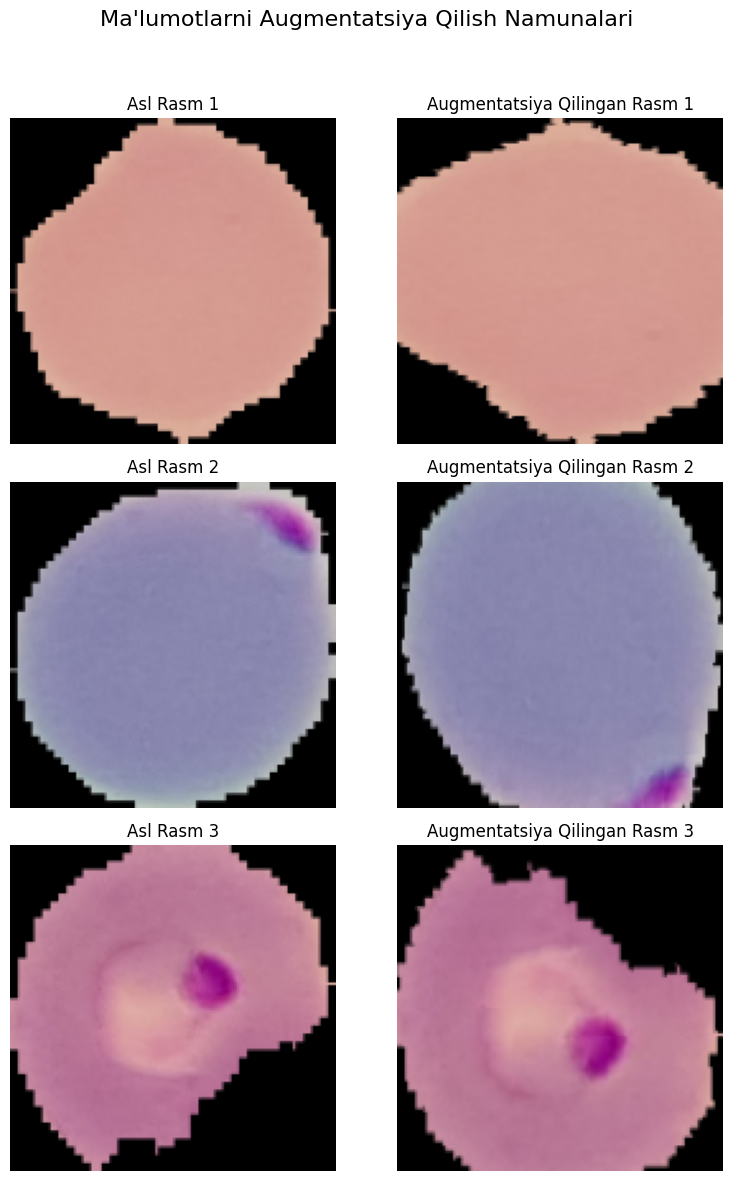

In [18]:
sample_image_paths_for_aug = train_paths[:3]

original_dataset = MalariaDataset(
    image_paths=sample_image_paths_for_aug,
    labels=[0]*len(sample_image_paths_for_aug), 
    target_size=(128, 128), 
    augment=False
)

augmented_dataset = MalariaDataset(
    image_paths=sample_image_paths_for_aug,
    labels=[0]*len(sample_image_paths_for_aug),
    target_size=(128, 128),
    augment=True
)

num_examples = len(sample_image_paths_for_aug)
plt.figure(figsize=(8, 4 * num_examples)) 
for i in range(num_examples):
    original_img_tensor, _ = original_dataset[i]
    augmented_img_tensor, _ = augmented_dataset[i]

    original_img_np = original_img_tensor.permute(1, 2, 0).cpu().numpy()
    augmented_img_np = augmented_img_tensor.permute(1, 2, 0).cpu().numpy()

    plt.subplot(num_examples, 2, i * 2 + 1)
    plt.imshow(original_img_np)
    plt.title(f"Asl Rasm {i+1}")
    plt.axis('off')

    plt.subplot(num_examples, 2, i * 2 + 2)
    plt.imshow(augmented_img_np)
    plt.title(f"Augmentatsiya Qilingan Rasm {i+1}")
    plt.axis('off')

plt.suptitle("Ma'lumotlarni Augmentatsiya Qilish Namunalari", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
def evaluate_model(model, test_loader, device, criterion):
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred_labels = [] 
    y_pred_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).squeeze() 
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0) 

            predicted_for_metrics = (outputs > 0.5).float() 

            y_true.extend(labels.cpu().numpy())
            y_pred_labels.extend(predicted_for_metrics.cpu().numpy())
            y_pred_scores.extend(outputs.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)

    y_true_tensor = torch.tensor(y_true)
    y_pred_labels_tensor = torch.tensor(y_pred_labels)
    test_acc = (y_pred_labels_tensor == y_true_tensor).sum().item() / len(y_true_tensor)

    return test_loss, test_acc, y_true, y_pred_labels, y_pred_scores

In [21]:
# Create datasets and dataloaders
batch_size = 32
train_dataset = MalariaDataset(train_paths, train_labels, augment=True)
val_dataset = MalariaDataset(val_paths, val_labels, augment=False)
test_dataset = MalariaDataset(test_paths, test_labels, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [28]:
# Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),nn.ReLU(),
            nn.Dropout(0.3),
            
            # CNNModel chiqish qatlami:
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)
    
# self.model = nn.Sequential(
#     # 3x [Conv2d -> (BatchNorm) -> ReLU -> MaxPool2d]
#     # Flatten
#     # Linear -> ReLU -> Dropout
#     # Linear -> Sigmoid
# )

In [29]:
# Modelni ishga tushirish
model = CNNModel().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
# Model keyinchalik o'qitiladi va bashorat qilish uchun ishlatiladi

In [30]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [10]:
# Function to display sample images
def plot_sample_images(image_paths, labels, num_samples=9):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(image_paths), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img = cv2.imread(image_paths[idx])
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title('Parazitlanmagan' if labels[idx] == 0 else 'Parazitlangan')
        plt.axis('off')
    plt.suptitle('Malariya Datasetidan Namuna Tasvirlar')
    plt.savefig('sample_images.png')
    plt.close()

plot_sample_images(train_paths, train_labels)

In [11]:
# Function to plot feature maps
def plot_feature_maps(model, image):
    model.eval()
    first_conv = model.model[0]  # First conv layer
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        feature_maps = first_conv(image)
    
    feature_maps = feature_maps.cpu().numpy()
    plt.figure(figsize=(15, 5))
    for i in range(min(8, feature_maps.shape[1])):
        plt.subplot(2, 4, i + 1)
        plt.imshow(feature_maps[0, i, :, :], cmap='viridis')
        plt.axis('off')
    plt.suptitle('Birinchi Konvolyutsion Qatlamdan Xususiyat Xaritalari')
    plt.savefig('feature_maps.png')
    plt.close()

In [12]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
        
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}: '
            f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
            f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return history

In [13]:
# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1/50: Train Loss: 0.2832, Train Acc: 0.8936, Val Loss: 0.1524, Val Acc: 0.9521
Epoch 2/50: Train Loss: 0.1683, Train Acc: 0.9495, Val Loss: 0.1450, Val Acc: 0.9566
Epoch 3/50: Train Loss: 0.1511, Train Acc: 0.9517, Val Loss: 0.1279, Val Acc: 0.9595
Epoch 4/50: Train Loss: 0.1465, Train Acc: 0.9518, Val Loss: 0.1188, Val Acc: 0.9617
Epoch 5/50: Train Loss: 0.1412, Train Acc: 0.9544, Val Loss: 0.1230, Val Acc: 0.9588
Epoch 6/50: Train Loss: 0.1361, Train Acc: 0.9555, Val Loss: 0.1272, Val Acc: 0.9597
Epoch 7/50: Train Loss: 0.1334, Train Acc: 0.9552, Val Loss: 0.1371, Val Acc: 0.9532
Epoch 8/50: Train Loss: 0.1352, Train Acc: 0.9558, Val Loss: 0.1187, Val Acc: 0.9617
Epoch 9/50: Train Loss: 0.1347, Train Acc: 0.9580, Val Loss: 0.1245, Val Acc: 0.9594
Epoch 10/50: Train Loss: 0.1309, Train Acc: 0.9554, Val Loss: 0.1236, Val Acc: 0.9612
Epoch 11/50: Train Loss: 0.1333, Train Acc: 0.9566, Val Loss: 0.1226, Val Acc: 0.9595
Epoch 12/50: Train Loss: 0.1341, Train Acc: 0.9573, Val Loss: 0

In [14]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

plot_training_history(history)


In [15]:
# Evaluate on test set
def evaluate_model(model, test_loader):
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    y_pred, y_true = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_acc = test_correct / test_total
    return test_loss, test_acc, y_true, y_pred

test_loss, test_accuracy, y_true, y_pred = evaluate_model(model, test_loader)
print(f'Test aniqligi: {test_accuracy:.4f}, Test yo‘qotishi: {test_loss:.4f}')

Test aniqligi: 0.9653, Test yo‘qotishi: 0.0969


In [16]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Parazitlanmagan', 'Parazitlangan'],
            yticklabels=['Parazitlanmagan', 'Parazitlangan'])
plt.title('Chalkashlik Matritsasi')
plt.xlabel('Bashorat')
plt.ylabel('Haqiqiy')
plt.savefig('confusion_matrix.png')
plt.close()

In [17]:
# Classification report and metrics
print('Tasniflash Hisoboti:')
print(classification_report(y_true, y_pred, target_names=['Parazitlanmagan', 'Parazitlangan']))

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Tasniflash Hisoboti:
                 precision    recall  f1-score   support

Parazitlanmagan       0.96      0.97      0.97      2756
  Parazitlangan       0.97      0.96      0.97      2755

       accuracy                           0.97      5511
      macro avg       0.97      0.97      0.97      5511
   weighted avg       0.97      0.97      0.97      5511

Precision: 0.9672
Recall: 0.9633
F1-Score: 0.9653


In [18]:
# Display feature maps for a sample image
sample_image, _ = train_dataset[0]
plot_feature_maps(model, sample_image)

In [19]:
# Assuming 'model' is your trained CNNModel instance
MODEL_SAVE_PATH = 'malaria_model.pth' # Using .pth convention for state_dict
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model state_dict saved to {MODEL_SAVE_PATH}")

Model state_dict saved to malaria_model.pth


In [21]:
torch.save(model.state_dict(), 'malaria_model.pth')

In [43]:

model = CNNModel()
model.load_state_dict(torch.load('malaria_model.pth', map_location=device))
model.to(device)
model.eval()

criterion = nn.BCELoss()

test_loss, test_accuracy, y_true_test, y_pred_labels_test, y_scores_test = evaluate_model(model, test_loader, device, criterion)

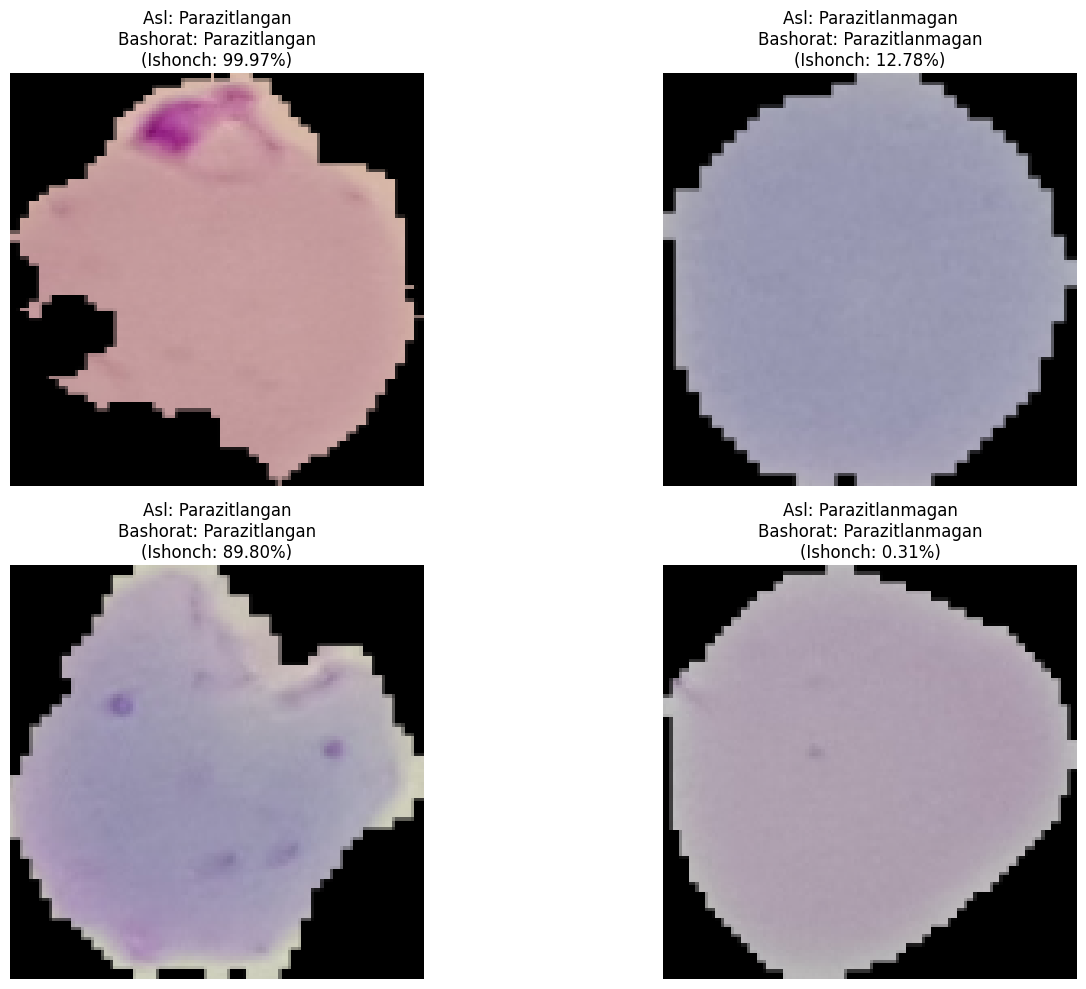

In [ ]:

num_display_samples = 4

display_indices = range(num_display_samples) 

plt.figure(figsize=(15, 5 * num_display_samples // 2 if num_display_samples > 1 else 6)) 
for i, idx in enumerate(display_indices):
    img_path_sample = test_paths[idx]
    true_label_sample = "Parazitlangan" if y_true_test[idx] == 1 else "Parazitlanmagan"
    pred_label_sample = "Parazitlangan" if y_pred_labels_test[idx] == 1 else "Parazitlanmagan"
    pred_score_sample = y_scores_test[idx]

    img_sample = cv2.imread(img_path_sample)
    img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB) 
    img_sample = cv2.resize(img_sample, (128,128))

    plt.subplot( (num_display_samples + 1) // 2, 2, i + 1)
    plt.imshow(img_sample)
    title_str = f"Asl: {true_label_sample}\nBashorat: {pred_label_sample}\n(Ishonch: {pred_score_sample*100:.2f}%)"
    plt.title(title_str)
    plt.axis('off')
plt.tight_layout()
plt.show()

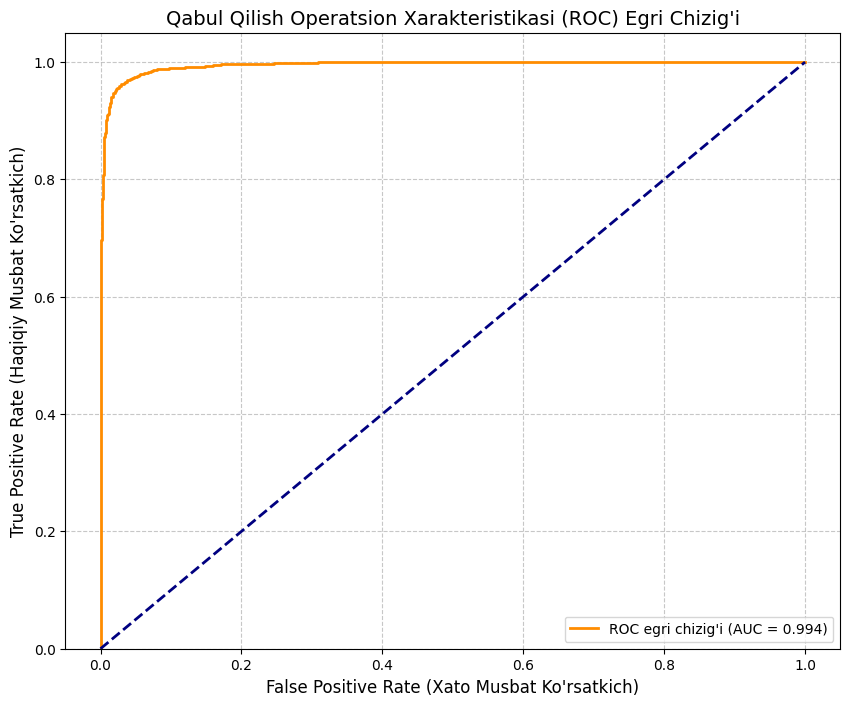

ROC AUC qiymati: 0.9944


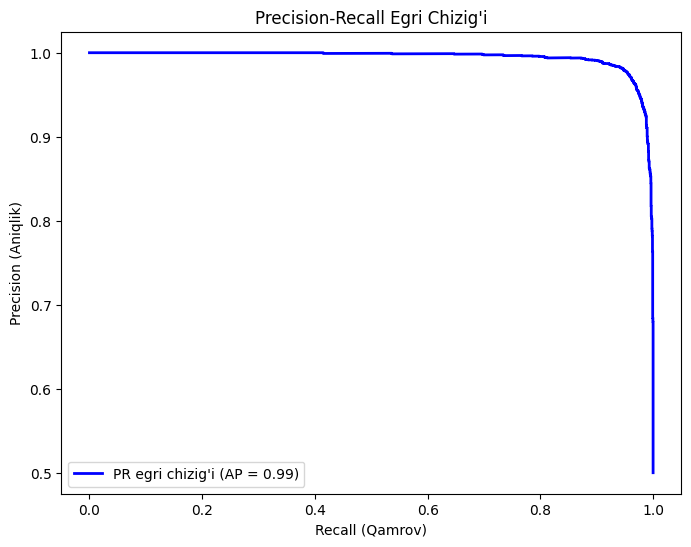

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fpr, tpr, thresholds_roc = roc_curve(y_true_test, y_scores_test)

# ROC egri chizig'i ostidagi maydonni (AUC - Area Under Curve) hisoblash
roc_auc = auc(fpr, tpr)

# Grafikni chizish
plt.figure(figsize=(10, 8)) 
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC egri chizig\'i (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate (Xato Musbat Ko\'rsatkich)', fontsize=12)
plt.ylabel('True Positive Rate (Haqiqiy Musbat Ko\'rsatkich)', fontsize=12)
plt.title('Qabul Qilish Operatsion Xarakteristikasi (ROC) Egri Chizig\'i', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)   
plt.savefig('images/roc_curve.png') 
plt.show()

print(f"ROC AUC qiymati: {roc_auc:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_test, y_scores_test)
ap = average_precision_score(y_true_test, y_scores_test)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR egri chizig\'i (AP = {ap:.2f})')
plt.xlabel('Recall (Qamrov)')
plt.ylabel('Precision (Aniqlik)')
plt.title('Precision-Recall Egri Chizig\'i')
plt.legend(loc="best")
# plt.savefig('images/pr_curve.png')
plt.show()


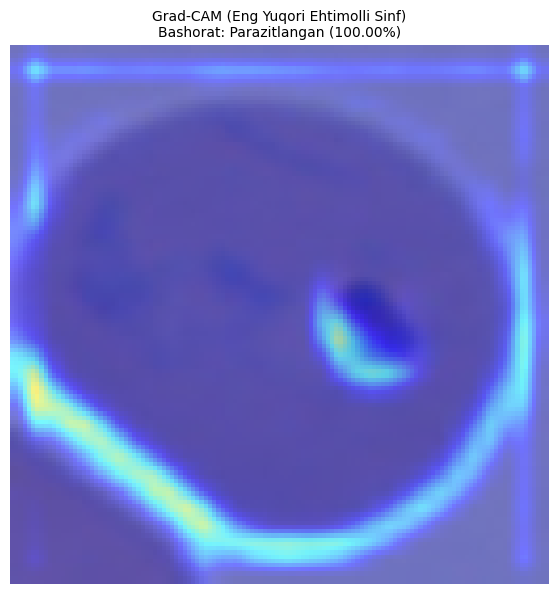

Grad-CAM vizualizatsiyasi muvaffaqiyatli yaratildi.


In [9]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

targets = None 

cam_algorithm_instance = GradCAM(model=model, target_layers=target_layers)
grayscale_cam_processed = None 

try:
    grayscale_cam_result = cam_algorithm_instance(input_tensor=input_tensor,
                                                targets=targets,
                                                aug_smooth=True,
                                                eigen_smooth=True)
    if grayscale_cam_result is not None:
        grayscale_cam_processed = grayscale_cam_result[0, :] 
    else:
        print("Xatolik: CAM algoritmi 'None' qiymat qaytardi.")

except Exception as e:
    print(f"Grad-CAM hisoblashda xatolik yuz berdi: {e}")
    print("Iltimos, `target_layers`, `input_tensor` formatini va `targets` ni tekshiring.")

if grayscale_cam_processed is not None:
    rgb_img_for_display = np.array(pil_image) / 255.0
    cam_image = show_cam_on_image(rgb_img_for_display, grayscale_cam_processed, use_rgb=True)

    # Sarlavha uchun model bashoratini olish
    with torch.no_grad(): # Bu qismni ham oldinroq hisoblab olishingiz mumkin
        output_prob = model(input_tensor).squeeze().item()
        predicted_class_idx = (output_prob > 0.5)
    class_names = ['Yuqtirilmagan', 'Parazitlangan'] # Sizning sinf nomlaringiz
    predicted_class_name = class_names[int(predicted_class_idx)]
    target_display_name = "Eng Yuqori Ehtimolli Sinf" if targets is None else class_names[targets[0].category if targets else int(predicted_class_idx)]


    plt.figure(figsize=(7, 7))
    plt.imshow(cam_image)
    plt.title(f"Grad-CAM ({target_display_name})\nBashorat: {predicted_class_name} ({output_prob*100:.2f}%)", fontsize=10)
    plt.axis('off')
    # plt.savefig('images/grad_cam_final_result.png') # Fayl nomini o'zgartirishingiz mumkin
    plt.show()
    print("Grad-CAM vizualizatsiyasi muvaffaqiyatli yaratildi.")
else:
    print("Grad-CAM vizualizatsiyasi yaratilmadi (xatolik yoki 'None' natija).")